# Local registration with ICP

In the RGBD folder we have the first 400 images from one of the datasets from: [http://redwood-data.org/indoor_lidar_rgbd/download.html](http://redwood-data.org/indoor_lidar_rgbd/download.html)

In [2]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import copy
        
# Helper function to draw registrations (reccomended)
def draw_registrations(source, target, transformation = None, recolor = False):
        source_temp = copy.deepcopy(source)
        target_temp = copy.deepcopy(target)
        if(recolor):
            source_temp.paint_uniform_color([1, 0.706, 0])
            target_temp.paint_uniform_color([0, 0.651, 0.929])
        if(transformation is not None):
            source_temp.transform(transformation)
        o3d.visualization.draw_geometries([source_temp, target_temp])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Creating point clouds from image data
Now we are going to try to create our own point clouds from RGB+depth images.
First, we load two RGBD images.

In [46]:
# Read in images. We have images 000000 - 0000400
color_raw0 = o3d.io.read_image("RGBD/color/000000.jpg")
depth_raw0 = o3d.io.read_image("RGBD/depth/000000.png")

color_raw1 = o3d.io.read_image("RGBD/color/000005.jpg")
depth_raw1 = o3d.io.read_image("RGBD/depth/000005.png")

Create point clouds from rgb + depth images.

If you set `convert_rgb_to_intensity = False` you will retain the colors from the rgb image.

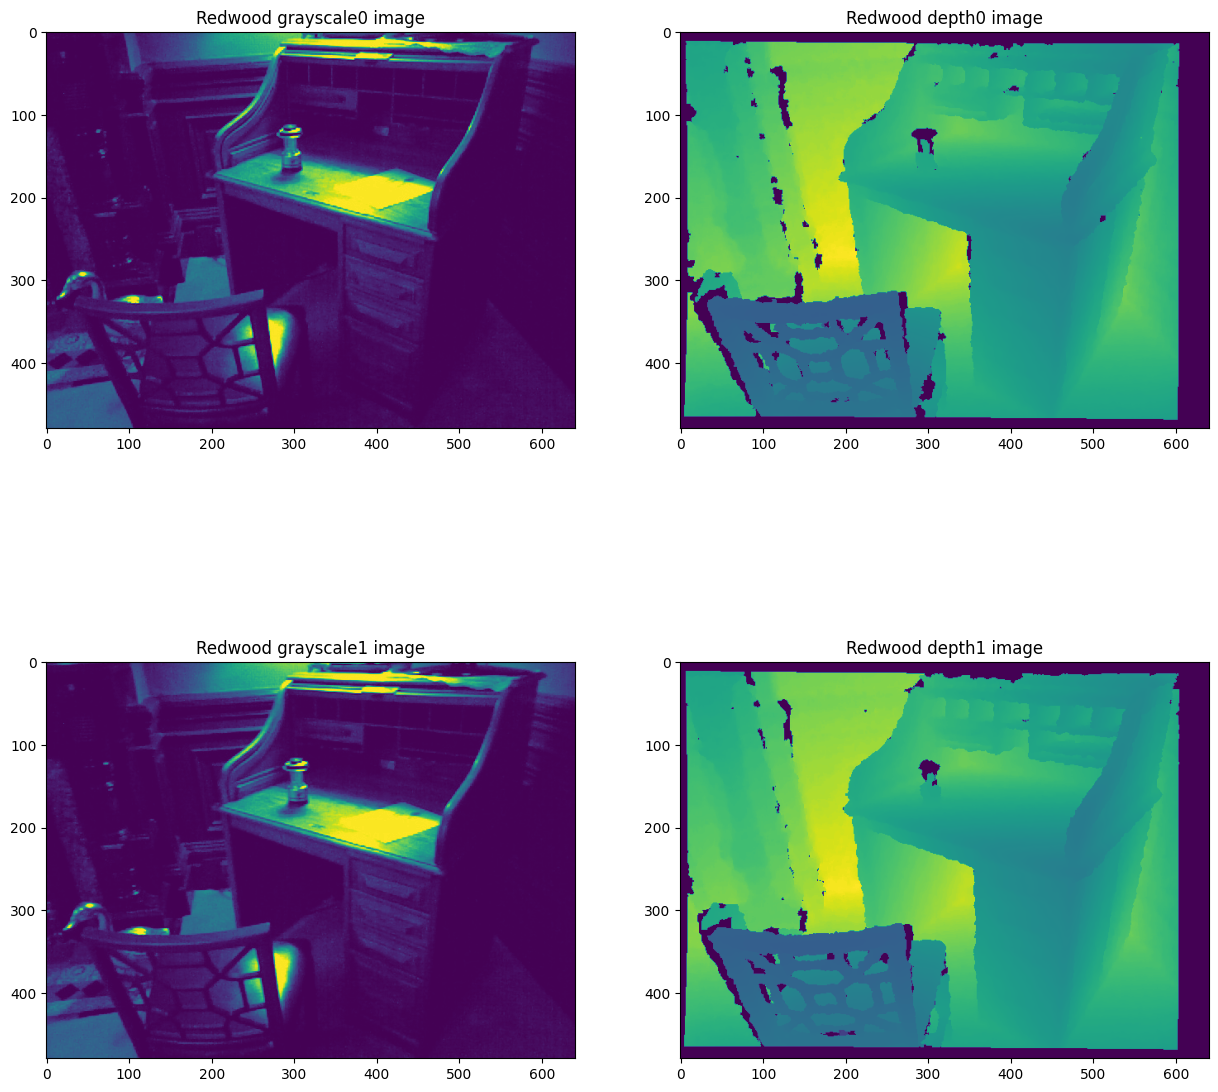

In [41]:
rgbd_image0 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw0, 
    depth_raw0, 
    convert_rgb_to_intensity = True)

rgbd_image1 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw1, 
    depth_raw1, 
    convert_rgb_to_intensity = True)

#show images
fig= plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('Redwood grayscale0 image')
plt.imshow(rgbd_image0.color)

plt.subplot(222)
plt.title('Redwood depth0 image')
plt.imshow(rgbd_image0.depth)

plt.subplot(223)
plt.title('Redwood grayscale1 image')
plt.imshow(rgbd_image1.color)

plt.subplot(224)
plt.title('Redwood depth1 image')
plt.imshow(rgbd_image1.depth)

plt.show()


## Images to point cloud
Now we create point clouds from the RGBD images we just loaded/created.


Here, we use `PinholeCameraIntrinsicParameters.PrimeSenseDefault` as default camera parameters. 

It has an image resolution of 640x480, focal length of ($f_x$, $f_y$) = (525.0, 525.0), and optical center ($c_x$, $c_y$) = (319.5, 239.5). 

An identity matrix is used as default extrinsic parameters. `pcd.transform` applies an up-down flip transformation on the point cloud for an improved visualization.


If execution becomes too slow you can downsample the point cloud.

In [45]:
# Source pointcloud
camera = o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

source = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image0, camera)

# Target pointcloud
target = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image1, camera)

# Flip it, otherwise the pointcloud will be upside down
source.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
target.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

# Draw
draw_registrations(source, target, recolor=True)


### Evaluation of pointclouds

Before we can run ICP, we evaluate our source and target point clouds. This gives us a feeling if we need a better initial transformation or not.
From (http://www.open3d.org/docs/latest/tutorial/Basic/icp_registration.html):

"The function `evaluate_registration` calculates two main metrics. 
- `fitness` measures the overlapping area (# of inlier correspondences / # of points in target). The higher the better. 
- `inlier_rmse` measures the RMSE of all inlier correspondences. The lower the better.

In [21]:
# Parameters
threshold = 0.02
trans_init = np.asarray([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

#Evaluate registration
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(source, target, threshold, trans_init)
print(evaluation)

Initial alignment
RegistrationResult with fitness=9.176427e-01, inlier_rmse=9.789196e-03, and correspondence_set size of 240059
Access transformation to get result.


## ICP

Now try to call icp with your point clouds and your initial transformation.

Initially we use:
```Python
point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()
icp_result = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    point_to_plane)
```

In [39]:
##
#ICP code here
##
# Compute normal vectors for the target point cloud


# Run ICP with point-to-plane distance
# point_to_plane = o3d.pipelines.registration.TransformationEstimationPointToPlane()
# icp_result = o3d.pipelines.registration.registration_icp(
#     source, target, max_correspondence_distance=0.02,
#     init=trans_init, estimation_method=point_to_plane)
# print(icp_result)
# draw_registrations(source, target, icp_result.transformation)
##
target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
point_to_plane = o3d.pipelines.registration.TransformationEstimationPointToPlane()
icp_result = o3d.pipelines.registration.registration_icp(source, target,0.02,
   trans_init, point_to_plane)
print(icp_result)
draw_registrations(source, target, icp_result.transformation, True)
draw_registrations(source, target, icp_result.transformation)

RegistrationResult with fitness=7.855002e-02, inlier_rmse=1.133690e-02, and correspondence_set size of 20549
Access transformation to get result.


# Exersices

### A)
If you increase the amount of steps from the original image so from i.e. 000000.jpg<>000005.jpg to 00000.jpg<>000300.jpg, what happens?
### B)
Can you tweak the parameters `threshold` and `trans_init` to combat some of the ill effects that starts appearing?
### C)
Again try to use 
```Python
point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()

reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    point_to_plane)
```

This requires you to find the normals for each point cloud use:
```python
    source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                            max_nn=30),fast_normal_computation=True)
```
Compare the resulting translations of the two methods. Is one better than the other?
### D)
Extend this and try to see how much of the bedroom you can reconstruct from the RGB and depth images.
You can extend a point cloud by `new = source + target`. Remember to resample the point cloud after a view additions so it does not get too large: `down_source = source.voxel_down_sample(voxel_size=0.05)`

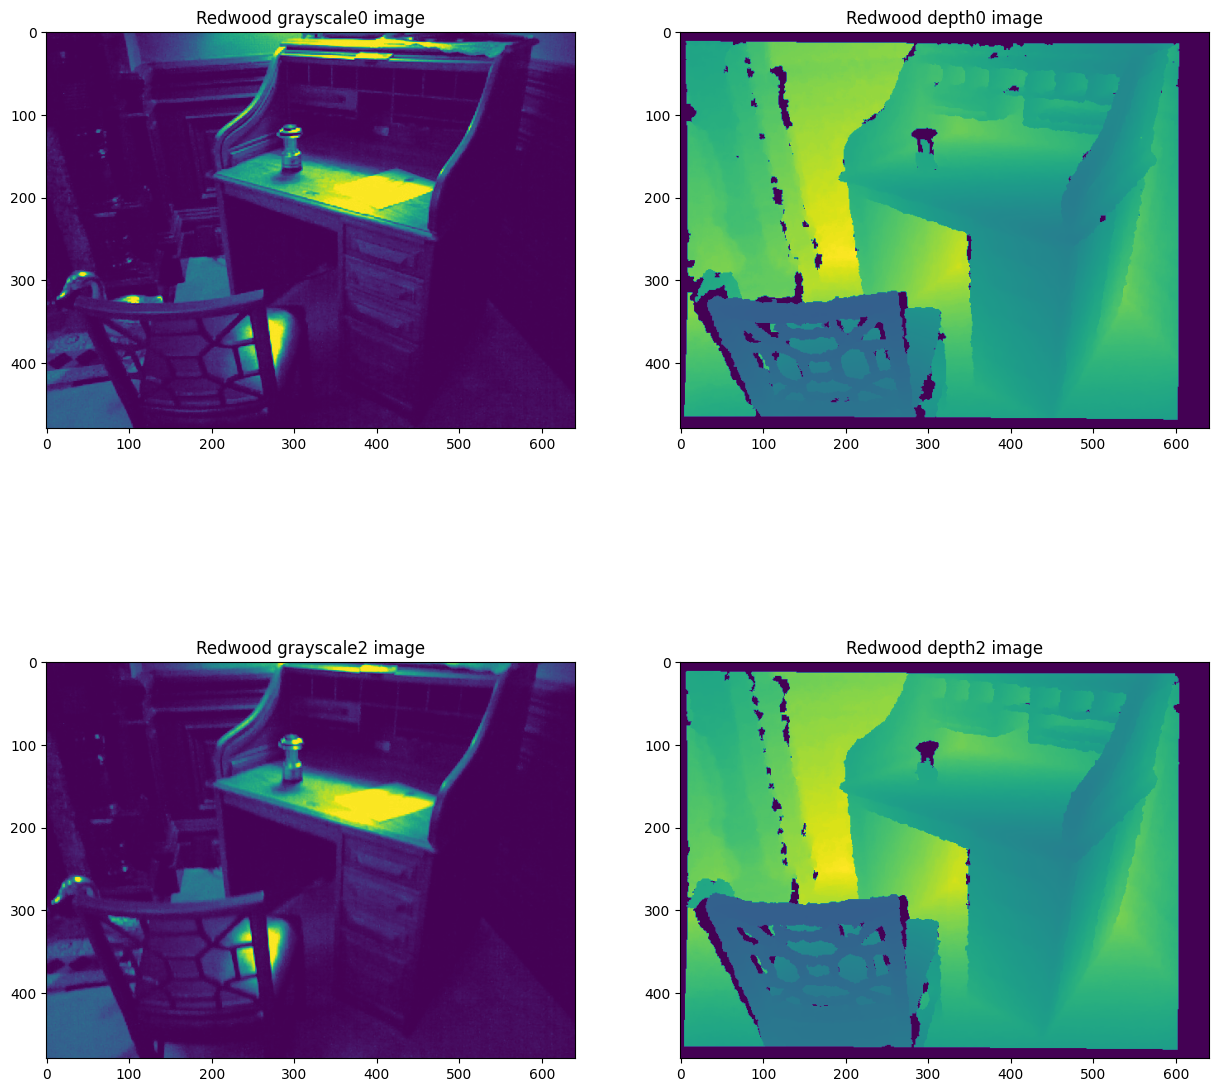

In [38]:
#A
# Read in images. We have images 000000 - 0000300
color_raw0 = o3d.io.read_image("RGBD/color/000000.jpg")
depth_raw0 = o3d.io.read_image("RGBD/depth/000000.png")

color_raw2 = o3d.io.read_image("RGBD/color/000030.jpg")
depth_raw2 = o3d.io.read_image("RGBD/depth/000030.png")

rgbd_image0 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw0, 
    depth_raw0, 
    convert_rgb_to_intensity = True)

rgbd_image2 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw2, 
    depth_raw2, 
    convert_rgb_to_intensity = True)

#show images
fig= plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('Redwood grayscale0 image')
plt.imshow(rgbd_image0.color)

plt.subplot(222)
plt.title('Redwood depth0 image')
plt.imshow(rgbd_image0.depth)

plt.subplot(223)
plt.title('Redwood grayscale2 image')
plt.imshow(rgbd_image2.color)

plt.subplot(224)
plt.title('Redwood depth2 image')
plt.imshow(rgbd_image2.depth)

plt.show()

In [63]:
#B
# Source pointcloud
camera = o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

source = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image0, camera)

# Target pointcloud
target = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image2, camera)

# Flip it, otherwise the pointcloud will be upside down
source.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
target.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

# Draw
target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
# draw_registrations(source, target, recolor=True)
threshold = 0.05
trans_init = np.eye(4)
point_to_plane = o3d.pipelines.registration.TransformationEstimationPointToPlane()
icp_result = o3d.pipelines.registration.registration_icp(source, target, threshold, trans_init, point_to_plane)
print(icp_result)
draw_registrations(source, target, icp_result.transformation)

RegistrationResult with fitness=2.237963e-01, inlier_rmse=2.451234e-02, and correspondence_set size of 58546
Access transformation to get result.


In [60]:
#C
# point_to_plane =  o3d.pipelines.registration.TransformationEstimationPointToPlane()

# reg_p2p = o3d.pipelines.registration.registration_icp(
#     source, target, threshold, trans_init,
#     point_to_plane)
# source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
#                             max_nn=30),fast_normal_computation=True)


import open3d as o3d

# Load the point clouds


target.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
# Compute normals for each point cloud
source.estimate_normals(
    o3d.geometry.KDTreeSearchParamHybrid(radius=0.5, max_nn=30),
    fast_normal_computation=True
)
target.estimate_normals(
    o3d.geometry.KDTreeSearchParamHybrid(radius=0.5, max_nn=30),
    fast_normal_computation=True
)

# Use point-to-plane ICP with pre-computed normals
point_to_plane = o3d.pipelines.registration.TransformationEstimationPointToPlane()
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target, threshold, trans_init,
    point_to_plane
)

# Use point-to-point ICP
reg_p2p = o3d.pipelines.registration.registration_icp(
    source, target,threshold, trans_init,
    o3d.pipelines.registration.TransformationEstimationPointToPoint()
)

print(reg_p2p.transformation)
icp_result = o3d.pipelines.registration.registration_icp(source, target, threshold, trans_init, point_to_plane)
draw_registrations(source, target, icp_result.transformation)

[[ 0.9998424  -0.00979578  0.01480597 -0.01796144]
 [ 0.01102328  0.99629975 -0.08523669 -0.10679054]
 [-0.01391622  0.08538647  0.99625072  0.00695199]
 [ 0.          0.          0.          1.        ]]


In [62]:
#D
# new = source + target
# down_source = source.voxel_down_sample(voxel_size=0.05)
# Load RGB and depth images

color_raw0 = o3d.io.read_image("RGBD/color/000000.jpg")
depth_raw0 = o3d.io.read_image("RGBD/depth/000000.png")

color_raw2 = o3d.io.read_image("RGBD/color/000300.jpg")
depth_raw2 = o3d.io.read_image("RGBD/depth/000300.png")

rgbd_image0 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw0, 
    depth_raw0, 
    convert_rgb_to_intensity = True)

rgbd_image2 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw2, 
    depth_raw2, 
    convert_rgb_to_intensity = True)
#print(rgbd_image2.width)
# Define depth sensor intrinsic matrix
#intrinsic = o3d.camera.PinholeCameraIntrinsic(width=rgbd_image0.width, height=rgb_image.height,
                                               #  fx=500, fy=500, cx=rgb_image.width/2,
                                               # cy=rgb_imag.height/2)

        
# # Source pointcloud
camera = o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

source = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image0, camera)

# Target pointcloud
target = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image2, camera)
new = source + target
down_source = source.voxel_down_sample(voxel_size=0.05)
# Flip it, otherwise the pointcloud will be upside down
source.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
target.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])        
# Project depth image to 3D point cloud
depth_scale = 1000.0
depth = o3d.geometry.Image(depth_raw0)
depth_point_cloud = o3d.geometry.PointCloud.create_from_depth_image(
    depth, camera, depth_scale=depth_scale)

# Colorize point cloud using RGB image
color = o3d.geometry.Image(color_raw0)
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color, depth, depth_scale=depth_scale, convert_rgb_to_intensity=False)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd, camera)

# Downsample point cloud
# down_pcd = pcd.voxel_down_sample(voxel_size=0.05)

# # Merge point clouds from multiple viewpoints
# source = down_pcd
for i in range(1, 5):
    # Load RGB and depth images from different viewpoint
    rgb_img_i = o3d.io.read_image(f"RGBD/color/00000{i}.png")
    depth_img_i = o3d.io.read_image(f"RGBD/depth/00000{i}.png")

    # Project depth image to 3D point cloud
    depth_i = o3d.geometry.Image(depth_img_i)
    depth_point_cloud_i = o3d.geometry.PointCloud.create_from_depth_image(
        depth_i, camera, depth_scale=depth_scale)

    # Colorize point cloud using RGB image
    color_i = o3d.geometry.Image(rgb_img_i)
    rgbd_i = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color_i, depth_i, depth_scale=depth_scale, convert_rgb_to_intensity=False)
    pcd_i = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_i, camera)

    # Downsample point cloud
    down_pcd_i = pcd_i.voxel_down_sample(voxel_size=0.05)

    # Merge point clouds
    source += down_pcd_i

# Visualize point cloud
o3d.visualization.draw_geometries([source])



[Open3D WARNING] Read PNG failed: unable to parse header.


RuntimeError: [Open3D Error] (class std::shared_ptr<class open3d::geometry::RGBDImage> __cdecl open3d::geometry::RGBDImage::CreateFromColorAndDepth(const class open3d::geometry::Image &,const class open3d::geometry::Image &,double,double,bool)) D:\a\Open3D\Open3D\cpp\open3d\geometry\RGBDImageFactory.cpp:40: Unsupported image format.
